## Load and reduce galaxy catalog

The initial (NED Local Volume Sample) catalog is available at the following url: https://ned.ipac.caltech.edu/NED::LVS/

A reduced version for galaxies closer than 150 Mpc, with duplicate entries (within 5 arcsec) removed, is available in this folder: https://drive.google.com/drive/folders/1M0o6B6UKuB0DE3b9mooW9IulC_U0rGev?usp=drive_link

The BG field list, the selection of BGLT fields and the HECATE catalog restricted to galaxies closer than 180 Mpc are available in the same folder.

In [114]:
from astropy.table import Table
import pandas as pd
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, SkyOffsetFrame
import astropy.units as u
from astropy.wcs import WCS
import json
import requests
from PIL import Image
import urllib
from matplotlib.patches import Circle



datadir = "Downloads/Catalogs/"

In [31]:
lvs = Table.read(datadir+"LVS_150.fits")
hec = Table.read(datadir+"HECATE_180.fits")

In [32]:
c1 = SkyCoord(lvs['ra'],lvs['dec'],frame='icrs',unit='deg')
c2 = SkyCoord(hec['RA'],hec['DEC'],frame='icrs',unit='deg')

# Match LVS and HECATE
idx,d2d,d3d = c1.match_to_catalog_sky(c2)

# Matching radius = 5 arcsec
ind = d2d.arcsec<5
idxind = idx[ind]

print(np.sum(ind), "LVS galaxies have a match in HECATE")

118206 LVS galaxies have a match in HECATE


* For galaxies with no SFR_hybrid, use SFR_W4
* For galaxies with no SFR or stellar mass, use HECATE values

In [27]:
mstar_missing = lvs['Mstar'].mask
print(np.sum(mstar_missing),"LVS galaxies with no Mstar")

sfr_missing = lvs['SFR_hybrid'].mask

# For galaxies with no SFR_hybrid, use SFR_W4
lvs['SFR_hybrid'][sfr_missing] = lvs['SFR_W4'][sfr_missing]

sfr_missing = lvs['SFR_hybrid'].mask
print(np.sum(sfr_missing),"LVS galaxies with no SFR")

# For galaxies with no SFR or stellar mass, use HECATE values
mstar_missing = np.logical_and(ind, mstar_missing)
sfr_missing = np.logical_and(ind, sfr_missing)

lvs['SFR_hybrid'][sfr_missing] = 10**hec['logSFR_HEC'][idx[sfr_missing]]
lvs['Mstar'][mstar_missing] = 10**hec['logM_HEC'][idx[mstar_missing]]

mstar_missing = lvs['Mstar'].mask
sfr_missing = lvs['SFR_hybrid'].mask
print(np.sum(mstar_missing),"LVS galaxies with no Mstar after HECATE completion")
print(np.sum(sfr_missing),"LVS galaxies with no SFR after HECATE completion")

44125 LVS galaxies with no Mstar
44489 LVS galaxies with no SFR
34286 LVS galaxies with no Mstar after HECATE completion
34735 LVS galaxies with no SFR after HECATE completion


## Keep only galaxies with valid SFR or Mstar and apply cuts

In [41]:
lvs = lvs[lvs['Mstar']>1e4]
lvs = lvs[lvs['SFR_hybrid']>0]
lvs['sSFR'] = lvs['SFR_hybrid']/lvs['Mstar']

print(len(lvs),"galaxies in clean sample")

67637 galaxies in clean sample


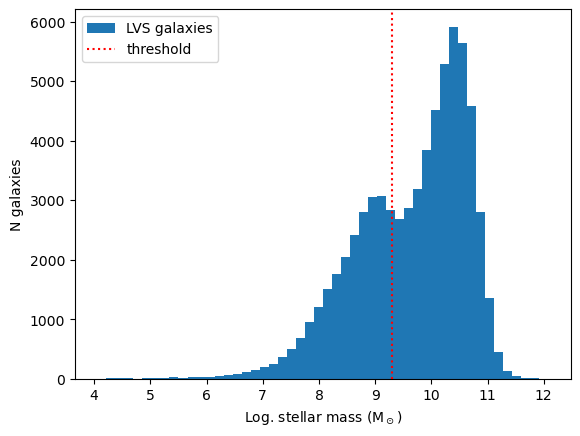

In [42]:
plt.hist(np.log10(lvs['Mstar']), bins=50, label='LVS galaxies')
plt.axvline(9.3, ls=':', color='r', label='threshold')
plt.xlabel("Log. stellar mass (M$_\odot$)")
plt.ylabel("N galaxies")
plt.legend()

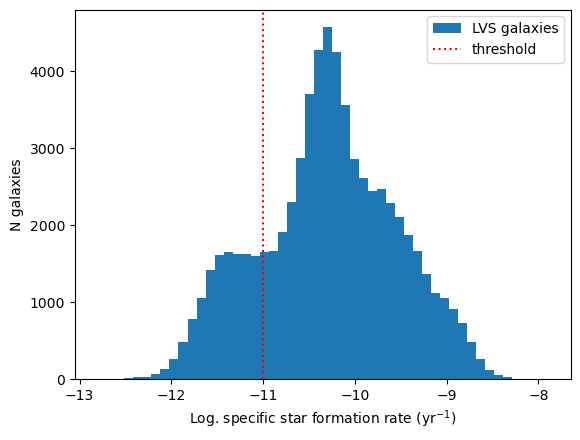

In [43]:
plt.hist(np.log10(lvs['sSFR']), bins=50, label='LVS galaxies')
plt.axvline(-11, ls=':', color='r', label='threshold')
plt.xlabel("Log. specific star formation rate (yr$^{-1}$)")
plt.ylabel("N galaxies")
plt.legend()

In [48]:
# apply cuts

lvs = lvs[np.logical_and(lvs['sSFR']>1e-11,lvs['Mstar']>2e9)]
lvs.write(datadir+"LVS_150_starforming.fits", overwrite=True)

print(len(lvs),"galaxies in massive starforming sample")

31369 galaxies in massive starforming sample


## Crossmatch with BlackGEM fields

The following function crossmatch the LVS galaxies positions to the coordinates of ML/BG fields.

A JSON file is generated to map each field to the corresponding LVS indexes

In [62]:
fields = pd.read_csv(datadir+"MLBG_FieldIDs_Oct2022.csv")
centers = SkyCoord(fields.ra.values*u.deg, fields.dec.values*u.deg, frame="icrs")
centers.transform_to(SkyOffsetFrame(origin=centers))

def coords2field(target, allfield = False):
    '''
    Returns the BlackGEM / MeerLICHT field IDS for a given position.

    Parameters
    ----------
    ra : float
        Right ascension of the position in degrees.
    dec : float
        Declination in degrees
        
    Returns
    -------
    fields : string or DataFrame
        The ID of the field(s) matching coordinates
    allfield: boolean
        Whether you want all fields matching coordinates or just one
    '''
    side = 1.64
    hside = side/2.
    
    
    target_centers = target.transform_to(SkyOffsetFrame(origin=centers))
    xi, eta = target_centers.lon, target_centers.lat

    contains_mask = (np.abs(xi) < hside*u.deg) * (np.abs(eta)< hside*u.deg)
        
    if allfield:
        return fields.iloc[contains_mask]['FieldID']
    else:
        return fields.iloc[contains_mask].iloc[0]['FieldID']


In [63]:
coo = SkyCoord(lvs['ra'], lvs['dec'],frame='icrs',unit='deg')
ra = coo.ra.deg
dec = coo.dec.deg

galids = {}
for i in tqdm(range(len(lvs))):
    fieldid_all = coords2field(coo[i],True)
    for j in range(len(fieldid_all)):
        f = int(fieldid_all.iloc[j])
        if f in galids.keys():
            galids[f].append(i)
            # new galaxy for the field, append to list
        else:
            galids[f] = [i]
            # first galaxy for the field, start a list



with open(datadir+"BGfields.json", "w") as outfile: 
    json.dump(galids, outfile)


100%|████████████████████████████████████████████████████████████████████████████| 31369/31369 [15:59<00:00, 32.69it/s]


In [234]:
fields = pd.read_csv(datadir+"MLBG_FieldIDs_Oct2022.csv")
ngal =  np.zeros(len(fields)).astype(int) # number of starforming massive LVS galaxies per field
mstar = np.zeros(len(fields)) # stellar mass from starforming massive LVS galaxies
sfrs =  np.zeros(len(fields)) # star formation rate from starforming massive LVS galaxies
mstar_alltypes = np.zeros(len(fields)) # stellar mass from whole LVS catalog (including ellipticals)

# Rough match to get total stellar mass - speed up computation (due to large catalog)
lvs_all = Table.read(datadir+"LVS_150.fits")
c1 = SkyCoord(lvs_all['ra'],lvs_all['dec'],frame='icrs',unit='deg')
c2 = SkyCoord(fields['ra'],fields['dec'],frame='icrs',unit='deg')
# Match LVS and BG fields
idx,d2d,d3d = c1.match_to_catalog_sky(c2)
sep_constraint = d2d.deg<1.64/2
print("matched LVS and BG fields")
fields['mtot_all'] = np.zeros(len(fields))
for i in tqdm(np.where(sep_constraint)[0]):
    fields['mtot_all'][idx[i]] += np.nansum([lvs_all[i]['Mstar']])


with open(datadir+'BGfields.json') as json_file:
    galids = json.load(json_file)

for i in tqdm(range(len(mstar))):
    f = str(fields['FieldID'][i])
    if f in galids.keys():
        mstar[i] = np.nansum(lvs['Mstar'][galids[f],])
        sfrs[i] = np.nansum(lvs['SFR_hybrid'][galids[f],])
        ngal[i] = len(galids[f])
        
fields['mtot'] = mstar
fields['sfrtot'] = sfrs
fields['ngal'] = ngal

bglt_orig = pd.read_csv(datadir+"BGLT2_FieldIDs.dat") # original BGLT fields
i_orig = np.isin(fields['FieldID'],bglt_orig['col1'])
fields['BGLT_orig'] =  i_orig

matched LVS and BG fields


  0%|                                                                                       | 0/139629 [00:00<?, ?it/s]C:\Users\hgtra\AppData\Local\Temp\ipykernel_3676\995298503.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fields['mtot_all'][idx[i]] += np.nansum([lvs_all[i]['Mstar']])
C:\Users\hgtra\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:96: UserWarning: Warning: converting a masked element to nan.
  a = np.asanyarray(a)
100%|███████████████████████████████████████████████████████████████████████████| 16080/16080 [00:18<00:00, 883.08it/s]


In [235]:
#Southern sky
isouth = fields['dec']<30
fields_south = fields.loc[isouth]

sfrs = sfrs[isouth]
mstar = mstar[isouth]
i_orig = i_orig[isouth]

In [236]:
# Define threshold
sfr_min = 15
ind = sfrs>sfr_min
fields_south.loc[:,'selected'] = ind

print(np.sum(ind), "fields are selected for having cumulative SFR > %.1f M$_\odot$/yr"%sfr_min)

fields_south.to_csv(datadir+"BGLT_fields_SFR_0624.csv")

174 fields are selected for having cumulative SFR > 15.0 M$_\odot$/yr


C:\Users\hgtra\AppData\Local\Temp\ipykernel_3676\4122004671.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fields_south.loc[:,'selected'] = ind


C:\Users\hgtra\AppData\Local\Temp\ipykernel_3676\1526549084.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(mstar[i_orig]),bins=np.linspace(8,13,50),histtype='step',label="Paul's fields",color='C3',ls='--',lw=2)
C:\Users\hgtra\AppData\Local\Temp\ipykernel_3676\1526549084.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(sfrs[i_orig]),bins=np.linspace(-1.5,4,80),histtype='step',label="Paul's fields",color='C3',ls='--',lw=2)


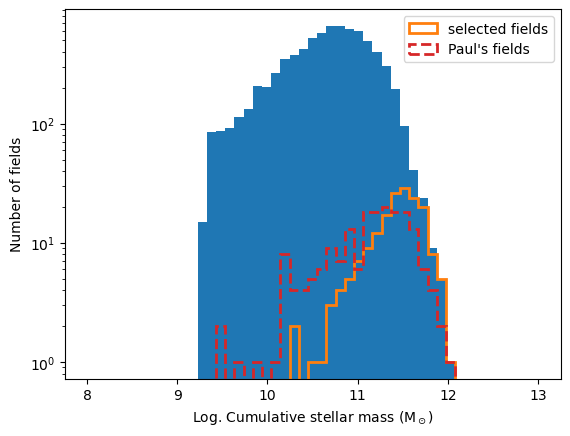

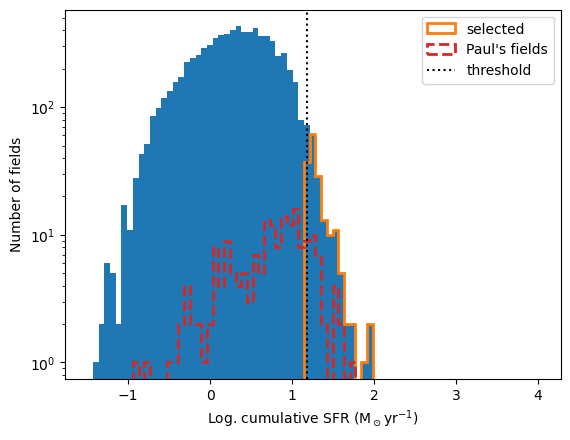

In [113]:
plt.figure()

plt.hist(np.log10(mstar[mstar>0]),bins=np.linspace(8,13,50))
plt.hist(np.log10(mstar[ind]),bins=np.linspace(8,13,50),histtype='step',label="selected fields",lw=2)
plt.hist(np.log10(mstar[i_orig]),bins=np.linspace(8,13,50),histtype='step',label="Paul's fields",color='C3',ls='--',lw=2)
plt.legend()
plt.ylabel("Number of fields")
plt.xlabel("Log. Cumulative stellar mass $\mathrm{(M_\odot)}$")
plt.gca().set_yscale('log')


plt.figure()
plt.hist(np.log10(sfrs[sfrs>0]),bins=np.linspace(-1.5,4,80))
plt.hist(np.log10(sfrs[ind]),bins=np.linspace(-1.5,4,80),histtype='step',label='selected',lw=2)
plt.hist(np.log10(sfrs[i_orig]),bins=np.linspace(-1.5,4,80),histtype='step',label="Paul's fields",color='C3',ls='--',lw=2)
plt.axvline(np.log10(sfr_min),color='k',ls=':',label='threshold')
plt.legend()
plt.xlabel("Log. cumulative SFR ($\mathrm{M_\odot yr^{-1}}$)")
plt.ylabel("Number of fields")
plt.gca().set_yscale('log')

In [106]:
frac = np.sum(fields_south['sfrtot'].loc[fields_south['selected']])/np.sum(fields_south['sfrtot'])
print("selection covers %.2f percents of local star formation rate"%(frac*100))

selection covers 14.94 percents of local star formation rate


In [107]:
print(np.sum(np.logical_and(fields_south['selected'],fields_south['BGLT_orig'])),"fields in common with Paul's selection")

32 fields in common with Paul's selection


New selection ranked by cumulative SFR:

In [237]:
fields_south.iloc[np.argsort(fields_south['sfrtot'])[::-1]]

FieldID         ra       dec      mtot_all          mtot     sfrtot  \
11919    11920  234.59715  24.10432  1.969913e+11  2.119799e+11  94.410740   
11918    11919  232.89099  24.10432  1.212237e+11  1.116072e+11  92.028808   
1389      1390  272.16000 -57.73602  4.360320e+11  1.703092e+11  76.469563   
12195    12196  349.61539  25.67818  6.420185e+11  3.841897e+11  58.282774   
9793      9794  351.27753   8.36580  3.648140e+11  3.839673e+11  50.475653   
...        ...        ...       ...           ...           ...        ...   
6221      6222   95.67567 -15.24200  1.534695e+11  0.000000e+00   0.000000   
6222      6223   97.29729 -15.24200  0.000000e+00  0.000000e+00   0.000000   
6223      6224   98.91891 -15.24200  1.560193e+11  0.000000e+00   0.000000   
6224      6225  100.54054 -15.24200  0.000000e+00  0.000000e+00   0.000000   
6370      6371  337.29730 -15.24200  1.208592e+11  0.000000e+00   0.000000   

       ngal  BGLT_orig  selected  
11919     5      False      True  
11918     4      False      True  
1389      7      False      True  
12195    14      False      True  
9793     10       True      True  
...     ...        ...       ...  
6221      0      False     False  
6222      0      False     False  
6223      0      False     False  
6224      0      False     False  
6370      0      False     False  

[12742 rows x 9 columns]

Old selection (ranked by cumulative stellar mass):

In [238]:
fields_south.iloc[np.argsort(fields_south['mtot_all'])[::-1]]

FieldID         ra       dec      mtot_all          mtot     sfrtot  \
5231      5232  257.26416 -23.11126  4.409046e+12  1.397756e+11   1.556701   
1363      1364  197.28001 -57.73602  3.695467e+12  0.000000e+00   0.000000   
12311    12312  194.04878  27.25203  3.665175e+12  3.520689e+11  11.173366   
9394      9395   78.94737   6.79195  3.512461e+12  7.325705e+11  33.623124   
16039    16100  243.88667 -60.90834  3.458319e+12  0.000000e+00   0.000000   
...        ...        ...       ...           ...           ...        ...   
6088      6089  239.72726 -16.81585  0.000000e+00  0.000000e+00   0.000000   
6081      6082  228.27272 -16.81585  0.000000e+00  0.000000e+00   0.000000   
6057      6058  189.00000 -16.81585  0.000000e+00  0.000000e+00   0.000000   
1530      1531  304.61539 -56.16217  0.000000e+00  0.000000e+00   0.000000   
1270      1271  285.00000 -59.30987  0.000000e+00  1.694356e+10   1.838276   

       ngal  BGLT_orig  selected  
5231      1       True     False  
1363      0      False     False  
12311    46       True     False  
9394     24       True      True  
16039     0       True     False  
...     ...        ...       ...  
6088      0      False     False  
6081      0      False     False  
6057      0      False     False  
1530      0      False     False  
1270      1      False     False  

[12742 rows x 9 columns]

Image of field with maximum sfr_tot:

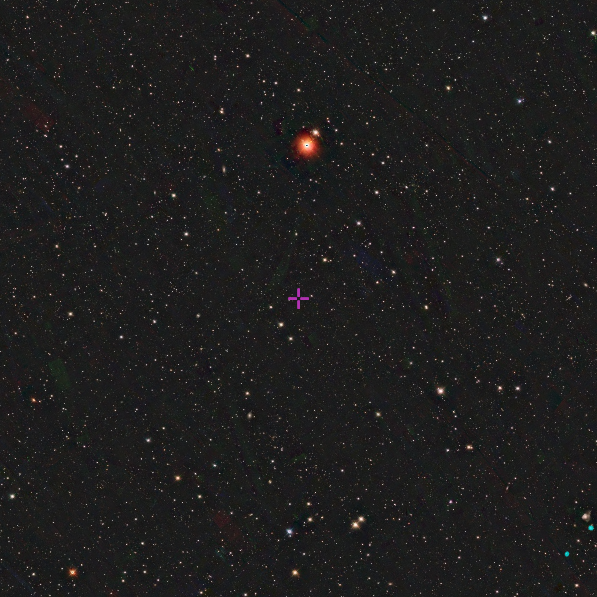

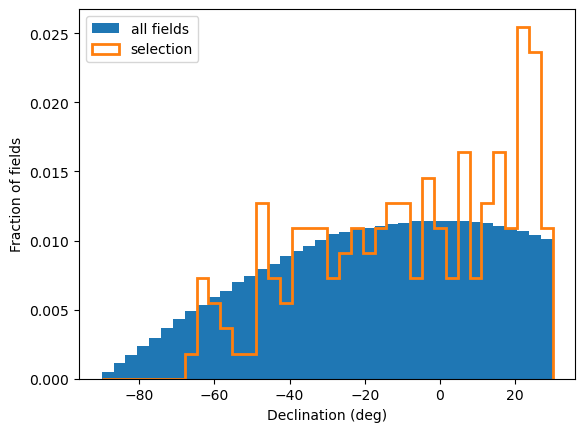

In [101]:
plt.hist(fields_south['dec'],bins=np.linspace(-90,30,39),density=True,label="all fields")
plt.hist(fields_south['dec'].loc[fields_south['selected']],bins=np.linspace(-90,30,39),histtype='step',lw=2,density=True,label="selection")
plt.ylabel("Fraction of fields")
plt.xlabel("Declination (deg)")
plt.legend()

## Get the images of the field of your choice and its galaxies

Retrieve a DSS image of the field and overlay approximate galaxy positions with circles.

https://archive.stsci.edu/cgi-bin/dss_search?v=dss1&r=272.16&d=-57.73602&e=J2000&h=100&w=100&f=gif
retrieved url
loaded image
(3531, 3531)
ESO 140- G 005 272.69845833332994 -58.15694444444 1150.3787551030732 2663.826630148595
IC 4686 273.411 -57.73252777778001 336.46802403109587 1744.8344671065147
IC 4687 273.415125 -57.72536111111 331.7565123545289 1729.4113587372788
IC 4687S 273.41783333333 -57.74819444444 328.66312576659584 1778.2150887964185
WISEA J181214.23-581503.3 273.059375 -58.250888888889996 738.0915317127385 2860.47498838869
WISEA J181337.91-582053.7 273.40791666667 -58.348305555559996 339.96316940814813 3062.6044859179083
WISEA J181117.79-574125.4 272.824125 -57.69052777778 1006.831182440703 1664.4298132026083


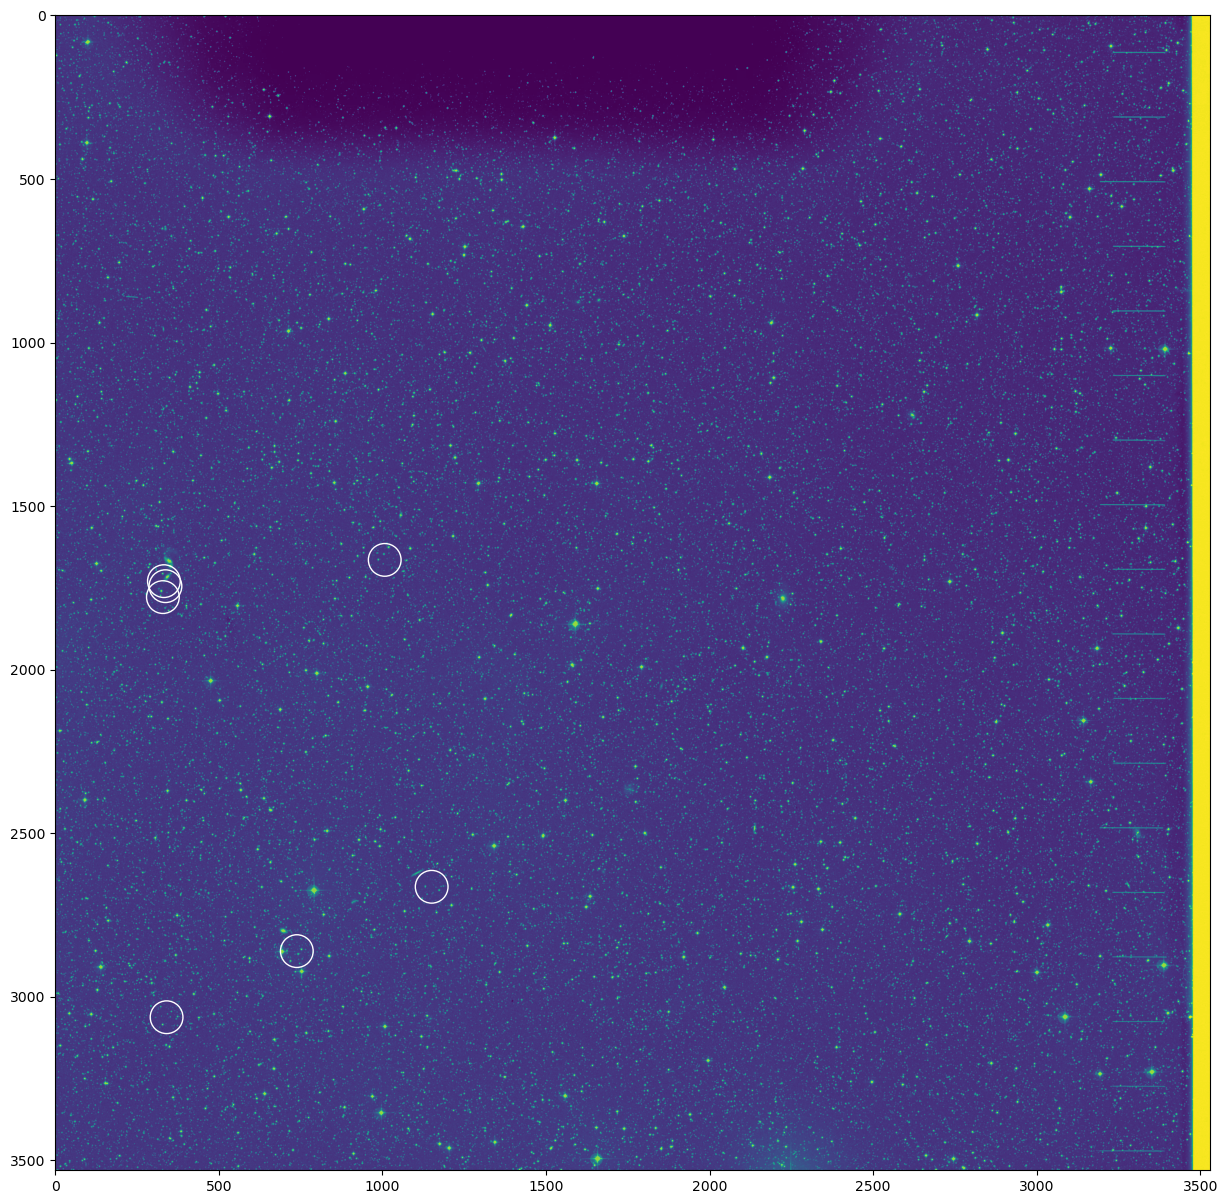

In [210]:
fieldid = 1390
fieldid = str(fieldid)

raf, decf = np.asarray(fields.loc[fields['FieldID']==int(fieldid),['ra','dec']])[0]
coof = SkyCoord(raf,decf,unit='deg',frame='icrs')


url = 'https://archive.stsci.edu/cgi-bin/dss_search?v=dss1&r=%s&d=%s&e=J2000&h=100&w=100&f=gif'%(raf,decf)
print(url)
cutout = requests.get(url, stream = True)
    
if cutout.status_code == 200:
    print("retrieved url")
    img = np.array(Image.open(cutout.raw))
    print("loaded image")
    print(img.shape)


fig, ax = plt.subplots(1, figsize=(15, 15))
ax.imshow(img)

gals = lvs[np.array(galids[fieldid]),]

scale = img.shape[0]/1.65 # pix per deg

rac, decc = corner.ra.deg, corner.dec.deg


for gal in gals:
    ra, dec = gal['ra'], gal['dec']
    sep = SkyCoord(ra,dec,unit='deg',frame='icrs').separation(coof).deg
    pa = SkyCoord(ra,dec,unit='deg',frame='icrs').position_angle(coof).rad
    
    #dx = SkyCoord(ra,decc,unit='deg',frame='icrs').separation(corner).deg
    #dy = SkyCoord(rac,dec,unit='deg',frame='icrs').separation(corner).deg
    #x, y = scale*dx, scale*dy
    x = img.shape[0]/2+sep*scale*np.sin(pa)
    y = img.shape[1]/2+sep*scale*np.cos(pa)
    
    circ = Circle((x,y),50,ec="w",fc="None")
    ax.add_patch(circ)
    print(gal['objname'],ra,dec,x,y)
    

    

Display images of galaxies in field

ESO 140- G 005
galaxy not in Legacy Survey footprint
IC 4686
galaxy not in Legacy Survey footprint
IC 4687
galaxy not in Legacy Survey footprint
IC 4687S
galaxy not in Legacy Survey footprint
WISEA J181214.23-581503.3
galaxy not in Legacy Survey footprint
WISEA J181337.91-582053.7
galaxy not in Legacy Survey footprint
WISEA J181117.79-574125.4
galaxy not in Legacy Survey footprint


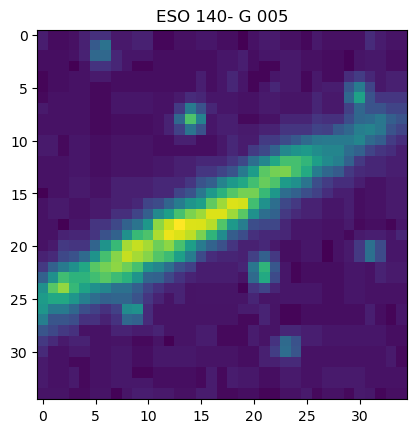

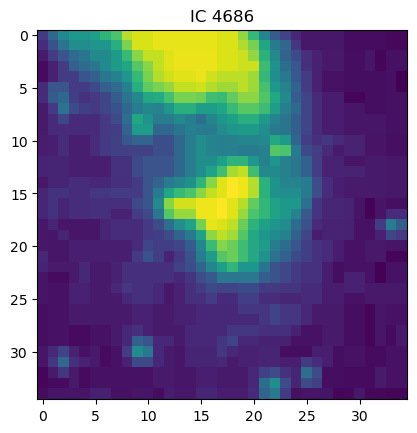

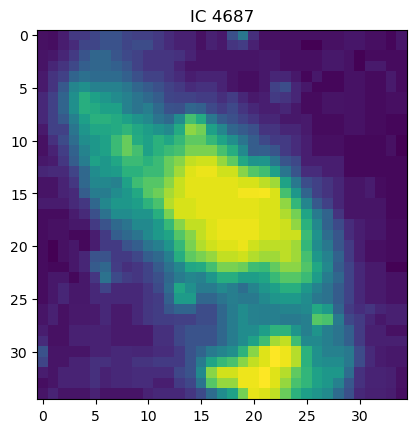

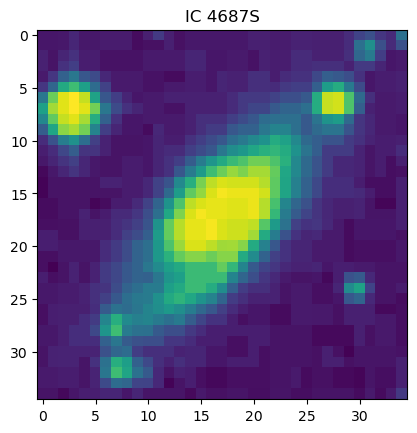

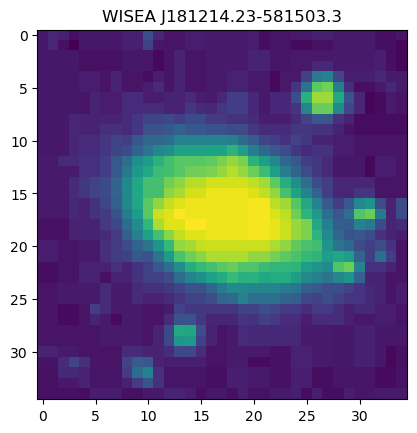

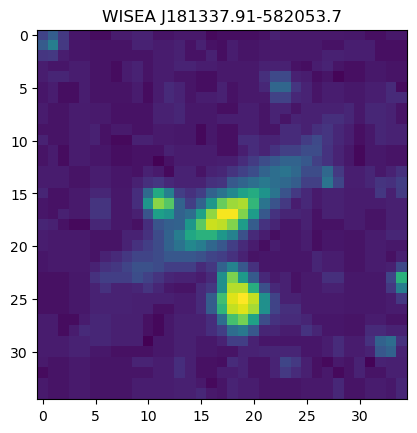

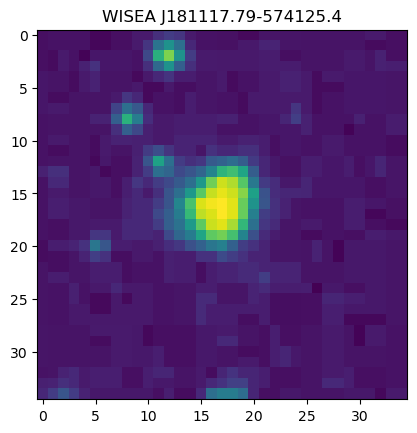

In [214]:

gals = lvs[np.array(galids[fieldid]),]

for gal in gals:
    print(gal['objname'])
    ra, dec = gal['ra'], gal['dec']
    b = SkyCoord(ra,dec,unit='deg',frame='icrs').galactic.b.deg
    if dec>30 or abs(b)<20:
        print("galaxy not in Legacy Survey footprint")
        url = 'https://archive.stsci.edu/cgi-bin/dss_search?v=dss1&r=%s&d=%s&e=J2000&h=1&w=1&f=gif'%(ra,dec)
    else:
        url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra=%s&dec=%s&layer=ls-dr10-grz&zoom=14'%(ra,dec)
    
    cutout = requests.get(url, stream = True)
    
    if cutout.status_code == 200:
        plt.figure()
        img = np.array(Image.open(cutout.raw))
        plt.title(gal['objname'])
        plt.imshow(img)

IC 1124
UGC 09916
WISEA J152838.29+232959.1
EASTERN NUCLEUS


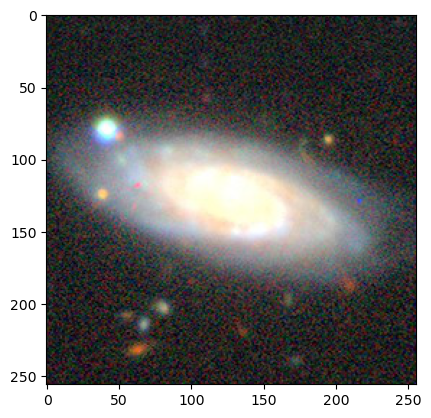

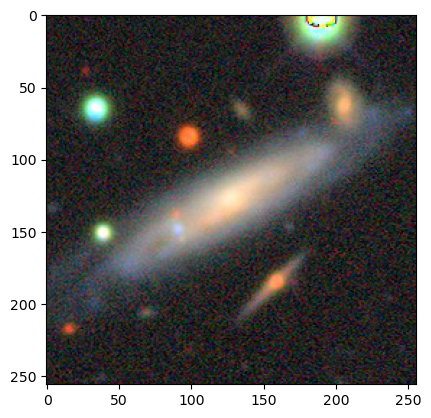

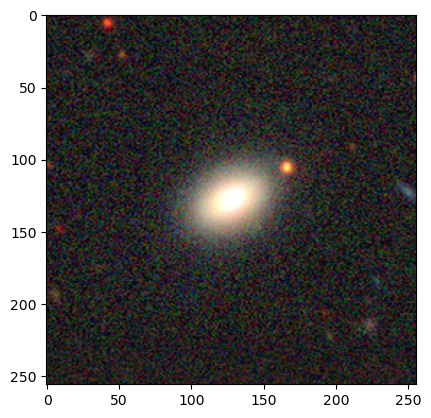

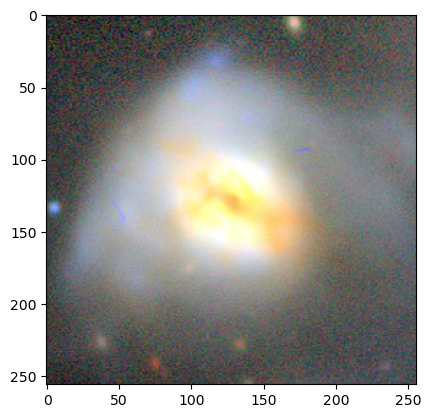

In [122]:
# display images of galaxies in field
fieldid = "11919"

gals = lvs[np.array(galids[fieldid]),]

for gal in gals:
    print(gal['objname'])
    ra, dec = gal['ra'], gal['dec']
    b = SkyCoord(ra,dec,unit='deg',frame='icrs').galactic.b.deg
    if dec>30 or abs(b)<20:
        print("galaxy not in Legacy Survey footprint")
        url = 'https://archive.stsci.edu/cgi-bin/dss_search?v=poss2ukstu_red&r=%s&d=%s&e=J2000&h=1&w=1&f=gif'%(ra,dec)
    else:
        url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra=%s&dec=%s&layer=ls-dr10-grz&zoom=14'%(ra,dec)
    
    cutout = requests.get(url, stream = True)
    
    if cutout.status_code == 200:
        plt.figure()
        img = np.array(Image.open(urllib.request.urlopen(url)))
        plt.imshow(img)